In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from utils.plotting import set_project_style

In [3]:
# 시각화 관련 기본 설정
set_project_style()

Seaborn style and Korean font (Malgun Gothic) applied.


In [4]:
# github 데이터셋
df_github = pd.read_csv('../dataset/github_all_years_cleaned.csv', encoding='utf-8')
df_github.head()

,id,name,full_name,owner,owner_type,description,language,stars,forks,watchers,...,topics,license,default_branch,has_wiki,has_pages,archived,period,search_text,ai_field,keyword
0,326059244,mirotalk,miroslavpejic85/mirotalk,miroslavpejic85,User,"🚀 WebRTC - P2P - Simple, Secure, Fast Real-Tim...",JavaScript,4015,680,4015,...,chatgpt|conference|conferencing|decentralized|...,GNU Affero General Public License v3.0,master,True,False,False,Before,"🚀 WebRTC - P2P - Simple, Secure, Fast Real-Tim...",LLM,NaN
1,326020989,TerrainAndAIPractice,tyler-lady/TerrainAndAIPractice,tyler-lady,User,A project I have used for general practice of ...,NaN,0,0,0,...,NaN,No License,main,True,False,False,Before,A project I have used for general practice of ...,Others,AI Agent
2,325951888,superpowers-skills,xitachixxx/superpowers-skills,xitachixxx,User,💪 Enhance your Claude Code superpowers with a ...,HTML,0,0,0,...,amazon-lex-chatbot|amazon-web-services|authent...,MIT License,main,True,False,False,Before,💪 Enhance your Claude Code superpowers with a ...,LLM,NaN
3,326066116,best-of-jupyter,ml-tooling/best-of-jupyter,ml-tooling,Organization,"🏆 A ranked list of awesome Jupyter Notebook, H...",NaN,1157,89,1157,...,awesome|best-of|best-of-list|collections|deep-...,Creative Commons Attribution Share Alike 4.0 I...,main,False,False,False,Before,"🏆 A ranked list of awesome Jupyter Notebook, H...",Others,NaN
4,326002236,ViT,FrancescoSaverioZuppichini/ViT,FrancescoSaverioZuppichini,User,Implementing Vi(sion)T(transformer),NaN,443,61,443,...,computer-vision|deep-learning,No License,main,True,False,False,Before,Implementing Vi(sion)T(transformer) computer-v...,NLP,NaN


In [5]:
# 날짜 데이터로 사용할 수 있게 형변환
df_github['created_at'] = pd.to_datetime(df_github['created_at'])
df_github['created_at'].head()

0   2021-01-01 21:31:15+00:00
1   2021-01-01 17:07:22+00:00
2   2021-01-01 09:40:45+00:00
3   2021-01-01 22:25:48+00:00
4   2021-01-01 15:14:05+00:00
Name: created_at, dtype: datetime64[ns, UTC]

In [6]:
# 'HTML', 'CSS' 제외 후 사용
df_lang = df_github.dropna(subset=['language'])
exclude_languages = ['HTML', 'CSS']
df_lang_filtered = df_lang[~df_lang['language'].isin(exclude_languages)]


In [7]:
# Top 10 선별
top_10_languages = df_lang_filtered['language'].value_counts().nlargest(10).index.tolist()
df_top10_lang = df_lang_filtered[df_lang_filtered['language'].isin(top_10_languages)]
print(f"Top 10 언어 필터링 완료: {top_10_languages}")

Top 10 언어 필터링 완료: ['Jupyter Notebook', 'Python', 'JavaScript', 'TypeScript', 'Java', 'C++', 'R', 'C#', 'Go', 'MATLAB']


In [ ]:
all_trends_list = [] # 빈 리스트 생성 (추세 데이터 보관용)

print("--- Top 10 언어별 시계열 분해 및 'Trend' 추출 시작 ---")
for lang in top_10_languages:
    print(f"  - {lang} 처리 중...")
    
    # 해당 언어 데이터만 선택
    lang_data = df_top10_lang[df_top10_lang['language'] == lang]
    
    # 월별 집계
    monthly_data = lang_data.set_index('created_at').resample('ME').size()
    
    # 분해 모델 결정 (0 값이 있으면 'additive')
    if (monthly_data <= 0).any():
        model_type = 'additive'
    else:
        model_type = 'multiplicative'
        
    # 시계열 분해 실행
    decomposition = seasonal_decompose(
        monthly_data, 
        model=model_type, 
        period=1
    )
    
    # 'Trend' 성분만 추출
    trend_data = decomposition.trend.reset_index() # .trend가 핵심
    trend_data['language'] = lang # 어느 언어의 추세인지 라벨링
    
    # 리스트에 추가
    all_trends_list.append(trend_data)

print("--- 모든 'Trend' 데이터 결합 완료 ---")

--- Top 10 언어별 시계열 분해 및 'Trend' 추출 시작 ---
  - Jupyter Notebook 처리 중...
  - Python 처리 중...
  - JavaScript 처리 중...
  - TypeScript 처리 중...
  - Java 처리 중...
  - C++ 처리 중...
  - R 처리 중...
  - C# 처리 중...
  - Go 처리 중...
  - MATLAB 처리 중...
--- 모든 'Trend' 데이터 결합 완료 ---


In [9]:
all_trends_df = pd.concat(all_trends_list, ignore_index=True)
# 컬럼 이름 변경 (분해 결과가 'trend' 컬럼명을 가짐)
all_trends_df.rename(columns={'trend': 'count_trend'}, inplace=True)
all_trends_df.head()

,created_at,count_trend,language
0,2021-01-31 00:00:00+00:00,6619.0,Jupyter Notebook
1,2021-02-28 00:00:00+00:00,6089.0,Jupyter Notebook
2,2021-03-31 00:00:00+00:00,6764.0,Jupyter Notebook
3,2021-04-30 00:00:00+00:00,6620.0,Jupyter Notebook
4,2021-05-31 00:00:00+00:00,8226.0,Jupyter Notebook


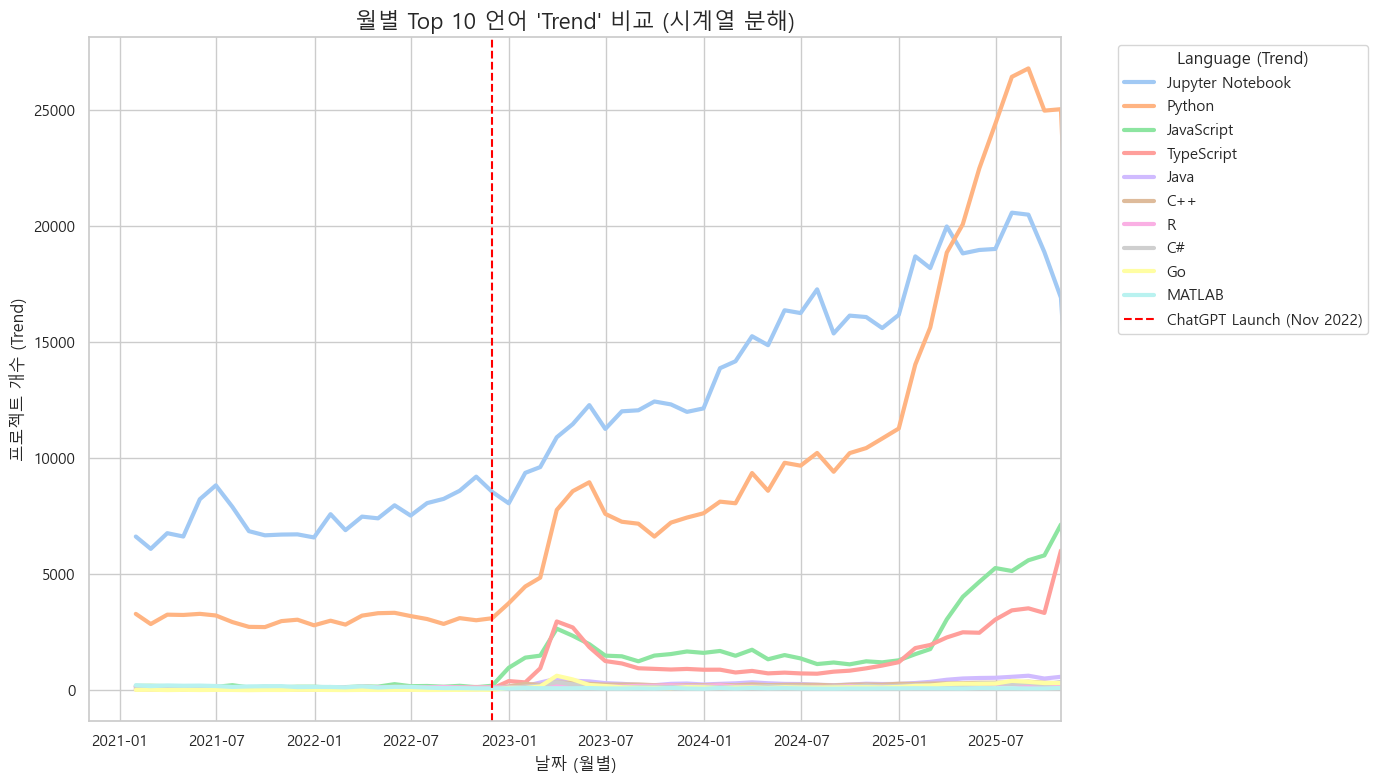

In [10]:
plt.figure(figsize=(14, 8))

# X축='created_at', Y축='count_trend', 색상='language'
sns.lineplot(
    data=all_trends_df,
    x='created_at',
    y='count_trend', # Y축이 'Trend' 값
    hue='language',
    linewidth=3.0 # 선을 더 굵게
)

# ChatGPT 출시일 (2022년 11월 30일)에 수직선 표시
plt.axvline(pd.to_datetime('2022-11-30'), color='red', linestyle='--', label='ChatGPT Launch (Nov 2022)')

plt.xlim(right = pd.to_datetime('2025-11-01'))

# 그래프 제목 및 라벨 설정
plt.title("월별 Top 10 언어 'Trend' 비교 (시계열 분해)", fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('프로젝트 개수 (Trend)', fontsize=12) # Y축이 'Trend'임

# 범례(Legend) 바깥쪽으로 빼기
plt.legend(title='Language (Trend)', bbox_to_anchor=(1.05, 1), loc='upper left')

# 레이아웃 자동 조절
plt.tight_layout()
plt.show()

In [11]:
# keywords 추출 'vibe Coding' 데이터는 비교적 너무 적어 제외
target_keywords = ['AI Agent', 'Autonomous']

# 'keyword' 컬럼이 target_keywords 리스트에 포함된 행만 필터링
df_agents = df_github[df_github['keyword'].isin(target_keywords)]

print(f"키워드 필터링 완료 (총 {len(df_agents)}개) ---")

if len(df_agents) == 0:
    print("경고: 'keyword' 컬럼에서 해당 키워드를 찾을 수 없습니다. 컬럼명이나 값을 확인하세요.")
else:
    print(df_agents['keyword'].value_counts())


키워드 필터링 완료 (총 44112개) ---
keyword
AI Agent      37274
Autonomous     6838
Name: count, dtype: int64


In [12]:
monthly_agents_data = df_agents.groupby([
    'keyword',
    pd.Grouper(key='created_at', freq='ME') # 'ME' = Month-End (월말 기준)
]).size().reset_index(name='count') # .size() -> .reset_index()로 DataFrame 변환

print("키워드별, 월별 집계 완료")
print(monthly_agents_data.head())

키워드별, 월별 집계 완료
    keyword                created_at  count
0  AI Agent 2021-01-31 00:00:00+00:00     15
1  AI Agent 2021-02-28 00:00:00+00:00     16
2  AI Agent 2021-03-31 00:00:00+00:00     21
3  AI Agent 2021-04-30 00:00:00+00:00     26
4  AI Agent 2021-05-31 00:00:00+00:00     15


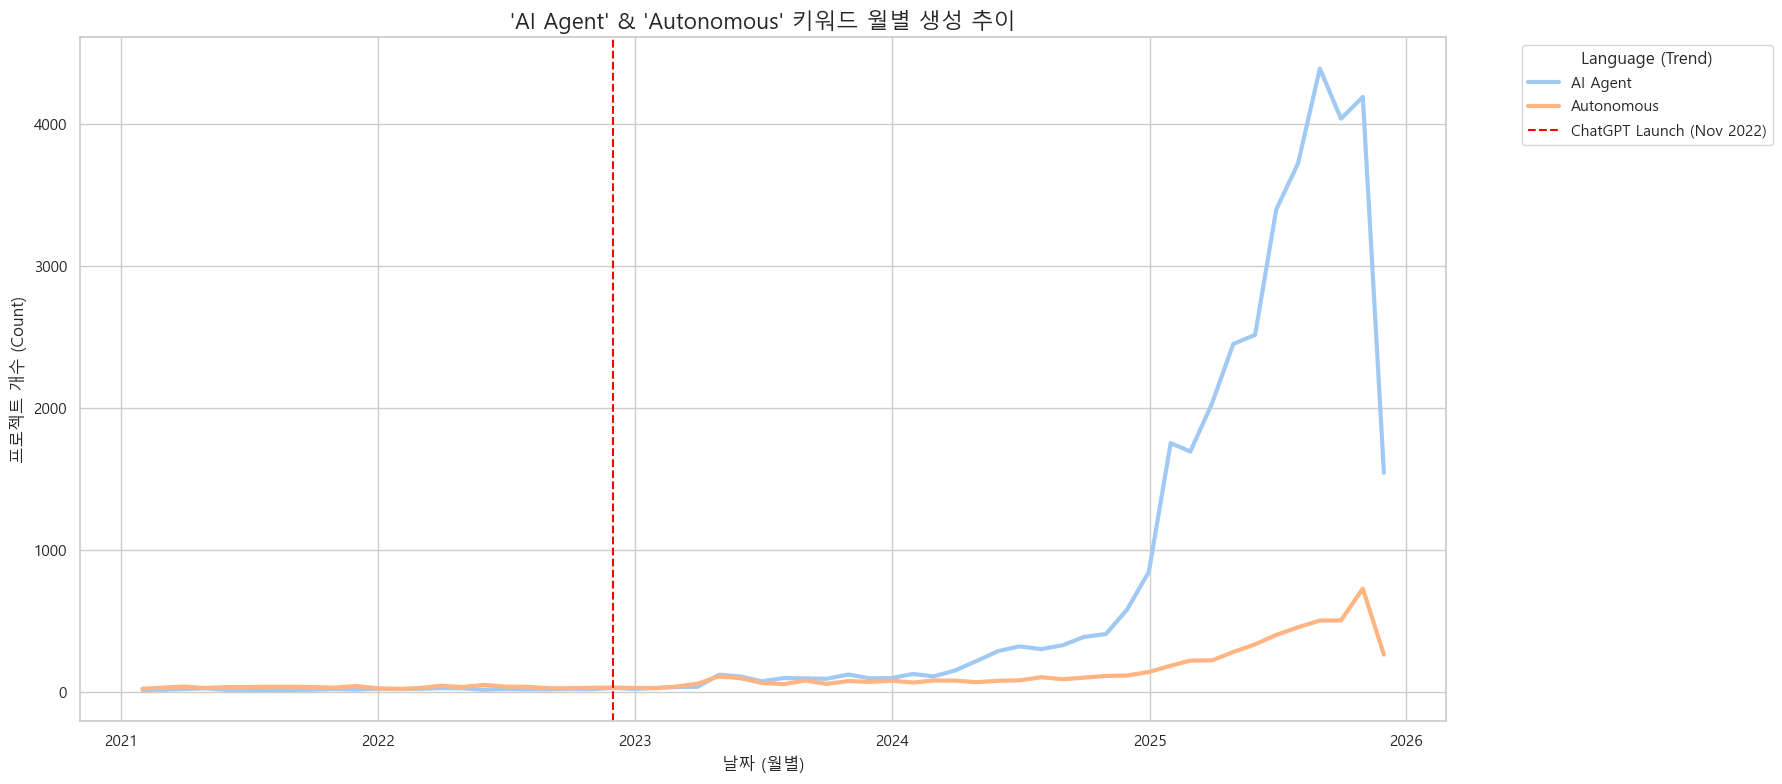

In [13]:
plt.figure(figsize=(18, 8)) 

sns.lineplot(
    data=monthly_agents_data,
    x='created_at',
    y='count',
    hue='keyword',
    linewidth=3.0
)

# ChatGPT 출시일 (2022년 11월 30일)에 수직선 표시
plt.axvline(pd.to_datetime('2022-11-30'), color='red', linestyle='--', label='ChatGPT Launch (Nov 2022)')


plt.title("'AI Agent' & 'Autonomous' 키워드 월별 생성 추이", fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('프로젝트 개수 (Count)', fontsize=12)
plt.legend(title='Language (Trend)', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()


plt.show()

In [14]:

# (이전과 동일: NaN 제거, HTML/CSS 제외)
df_lang = df_github.dropna(subset=['language'])
exclude_languages = ['HTML', 'CSS']
df_lang_filtered = df_lang[~df_lang['language'].isin(exclude_languages)]
top_10_languages = df_lang_filtered['language'].value_counts().nlargest(10).index.tolist()
print(f"Top 10 언어 리스트 확보: {top_10_languages}")

Top 10 언어 리스트 확보: ['Jupyter Notebook', 'Python', 'JavaScript', 'TypeScript', 'Java', 'C++', 'R', 'C#', 'Go', 'MATLAB']


In [15]:
# Top 10 언어 && 'AI Agent' 필터링
# 'Top 10 언어'에 해당하는 행만 먼저 필터링
df_top10 = df_github[df_github['language'].isin(top_10_languages)]

# 'AI Agent' 키워드만 다시 필터링
target_keyword = 'AI Agent'
df_top10_agent = df_top10[df_top10['keyword'] == target_keyword]

print(f"'Top 10 언어' 중 'AI Agent' 키워드 필터링 완료 (총 {len(df_top10_agent)}개)")

'Top 10 언어' 중 'AI Agent' 키워드 필터링 완료 (총 27245개)


In [16]:
# 언어별, 월별 개수 집계
# 이중 필터링된 데이터를 그룹화
monthly_top10_agent_data = df_top10_agent.groupby([
    'language',
    pd.Grouper(key='created_at', freq='ME') 
]).size().reset_index(name='count')

print("언어별, 월별 집계 완료")
print(monthly_top10_agent_data.head())

# 'monthly_top10_agent_data'에서 언어별로 'count'의 총합을 계산
legend_order_df = monthly_top10_agent_data.groupby('language')['count'].sum().reset_index()

# 'count'의 총합을 기준으로 내림차순 정렬
legend_order_df = legend_order_df.sort_values(by='count', ascending=False)

# 정렬된 'language' 이름만 리스트로 추출
legend_order_list = legend_order_df['language'].tolist()

언어별, 월별 집계 완료
  language                created_at  count
0       C# 2021-01-31 00:00:00+00:00      2
1       C# 2021-03-31 00:00:00+00:00      1
2       C# 2021-04-30 00:00:00+00:00      1
3       C# 2021-07-31 00:00:00+00:00      2
4       C# 2021-10-31 00:00:00+00:00      1


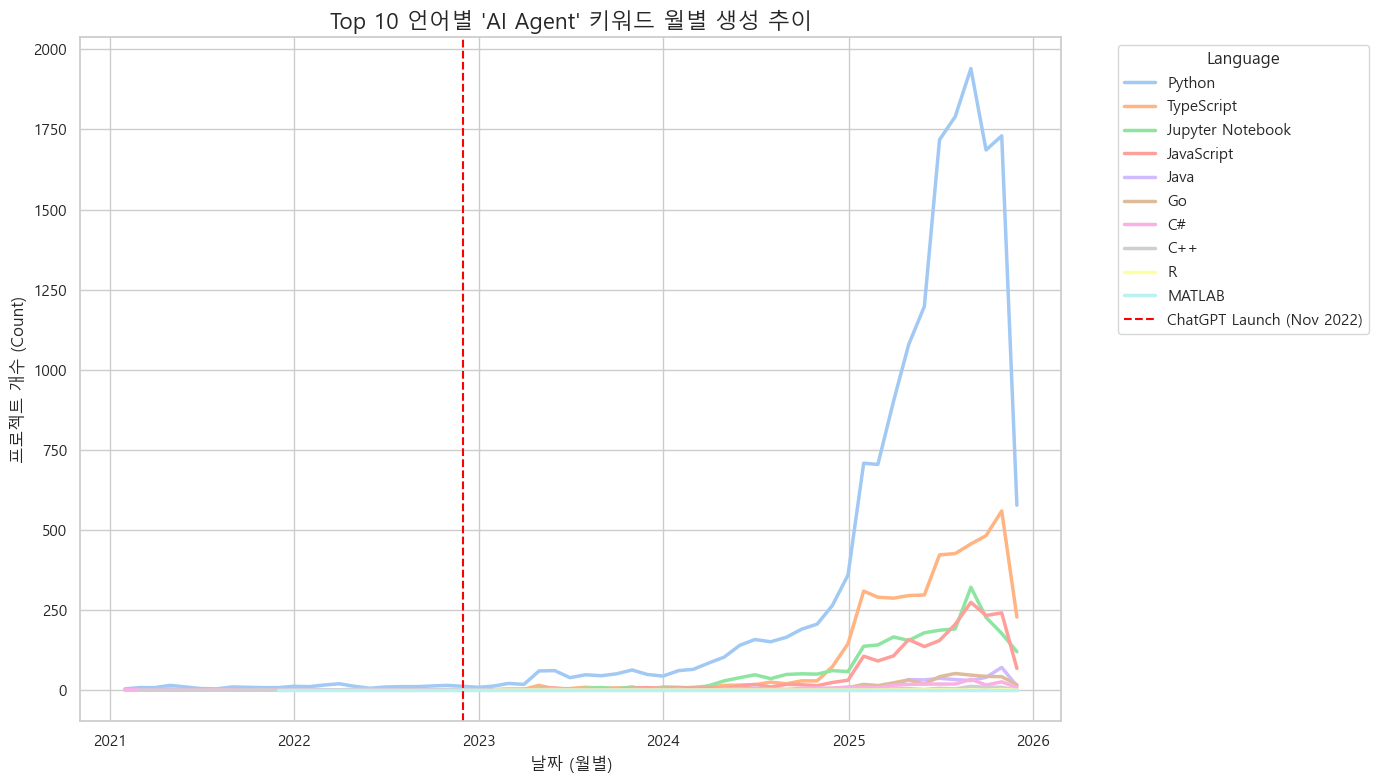

In [17]:
plt.figure(figsize=(14, 8)) 

sns.lineplot(
    data=monthly_top10_agent_data,
    x='created_at',
    y='count',
    hue='language',
    hue_order=legend_order_list,
    linewidth=2.5   
)

# ChatGPT 출시일 (2022년 11월 30일)에 수직선 표시
plt.axvline(pd.to_datetime('2022-11-30'), color='red', linestyle='--', label='ChatGPT Launch (Nov 2022)')

plt.title("Top 10 언어별 'AI Agent' 키워드 월별 생성 추이", fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('프로젝트 개수 (Count)', fontsize=12)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()